# MNIST digit classifier - Jorge Martínez (AIAO M2BI)

### Load modules

In [13]:
import numpy as np
from pandas import read_csv
from sklearn import preprocessing

# Tensorflow and keras import
import tensorflow as tf
from   tensorflow import keras
from   keras import Input, Model

# Utils to manipulate data
#from keras.utils import np_utils
from keras.utils import to_categorical

# Keras models
from keras.models import Sequential

# Keras layers
from keras.layers import Dense, Dropout
from keras.layers import TimeDistributed
from keras.layers import add
from keras.layers import Activation
from keras.layers import Conv1D, AveragePooling1D
from keras.layers import Flatten


# Callback (for learning/optimize)
from keras import callbacks

from keras.callbacks  import TensorBoard

# Data analysis and protocol
from sklearn.model_selection     import cross_val_score
from sklearn.model_selection     import train_test_split
from sklearn.model_selection     import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

### Load data and viasualise it

In [2]:
# Load the data
train_images = np.load('../data/train_images.npy')
train_labels = np.load('../data/train_labels.npy')
test_images = np.load('../data/test_images.npy')
test_labels = np.load('../data/test_labels.npy')

In [3]:
# Check shape of the data
print("Shape of the train images:", train_images.shape)
print("Number of train labels:", train_labels.shape)
print("Shape of the test images:", test_images.shape)
print("Number of test labels:", test_labels.shape)

# Check how many classes there are
print("Classes in the train set:", np.unique(train_labels))
print("Classes in the test set:", np.unique(test_labels))

Shape of the train images: (60000, 28, 28, 1)
Number of train labels: (60000,)
Shape of the test images: (10000, 28, 28, 1)
Number of test labels: (10000,)
Classes in the train set: [0 1 2 3 4 5 6 7 8 9]
Classes in the test set: [0 1 2 3 4 5 6 7 8 9]


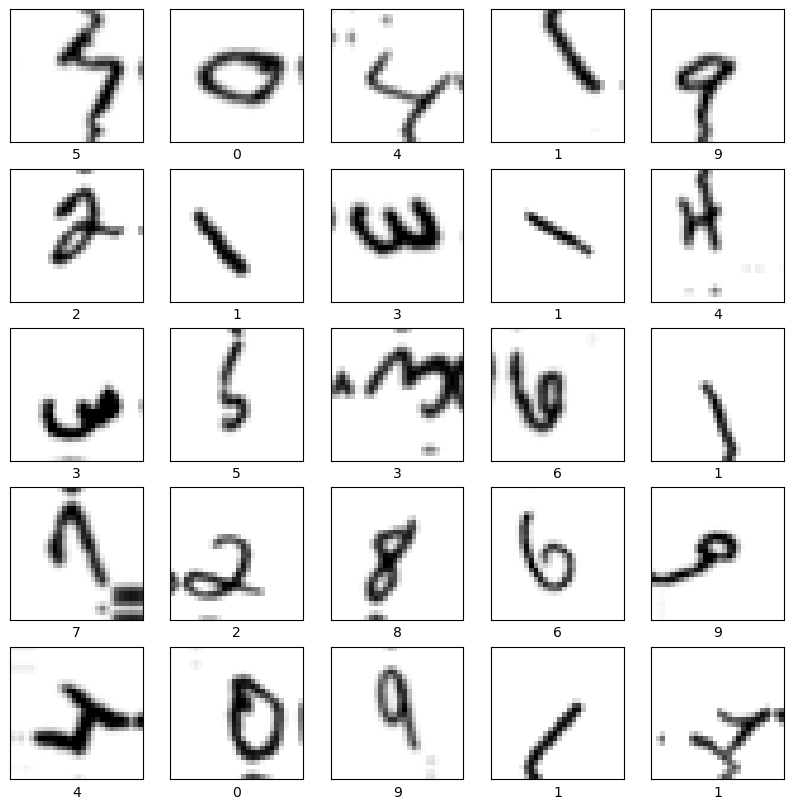

In [4]:
# Visualize the first 25 images
plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

plt.show()

## DNN model

### Prepare the data

In [5]:
# Pre-format the images
train_images_dnn = train_images.astype("float32")
test_images_dnn = test_images.astype("float32")

num_pixels = train_images_dnn.shape[1] * train_images_dnn.shape[2]

# Flatten images
train_images_dnn = train_images_dnn.reshape(train_images_dnn.shape[0], num_pixels)
test_images_dnn = test_images_dnn.reshape(test_images_dnn.shape[0], num_pixels)

# Normalization
train_images_dnn /= 255
test_images_dnn /= 255

# One-hot encoding the target labels
num_classes = len(np.unique(train_labels))
train_labels_dnn = keras.utils.to_categorical(train_labels, num_classes)
test_labels_dnn = keras.utils.to_categorical(test_labels, num_classes)

### Build the model

In [6]:
def dense_model(num_pixels, num_classes):
    model = Sequential([
        Dense(256, activation='relu', input_dim=num_pixels),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Then use it like this:
model1 = dense_model(num_pixels, num_classes)
model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [7]:
# Flatten the images
dense_history = model1.fit(train_images_dnn, train_labels_dnn, validation_split=0.2, epochs=20, batch_size=100)

Epoch 1/20


2024-09-24 00:44:54.501197: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


480/480 [==============================] - 1s 2ms/step - loss: 2.1832 - accuracy: 0.1942 - val_loss: 2.1135 - val_accuracy: 0.2264
Epoch 2/20
480/480 [==============================] - 1s 2ms/step - loss: 2.0106 - accuracy: 0.2785 - val_loss: 1.9058 - val_accuracy: 0.3159
Epoch 3/20
480/480 [==============================] - 1s 2ms/step - loss: 1.8214 - accuracy: 0.3550 - val_loss: 1.7021 - val_accuracy: 0.3994
Epoch 4/20
480/480 [==============================] - 1s 2ms/step - loss: 1.6798 - accuracy: 0.4078 - val_loss: 1.5575 - val_accuracy: 0.4608
Epoch 5/20
480/480 [==============================] - 1s 2ms/step - loss: 1.5705 - accuracy: 0.4541 - val_loss: 1.4453 - val_accuracy: 0.5016
Epoch 6/20
480/480 [==============================] - 1s 2ms/step - loss: 1.4716 - accuracy: 0.4931 - val_loss: 1.3316 - val_accuracy: 0.5477
Epoch 7/20
480/480 [==============================] - 1s 2ms/step - loss: 1.3866 - accuracy: 0.5227 - val_loss: 1.2768 - val_accuracy: 0.5691
Epoch 8/20
480/48

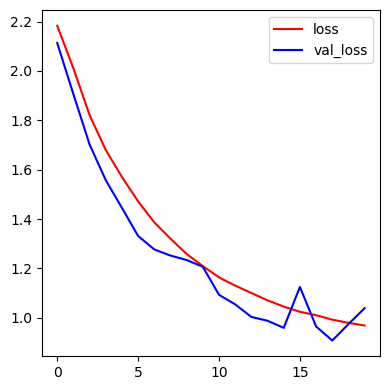

In [8]:
plt.figure(figsize = (4,4))
plt.plot(dense_history.history["loss"], color = "red", label = "loss")
plt.plot(dense_history.history["val_loss"], color = "blue", label = "val_loss")
plt.legend()
plt.tight_layout()

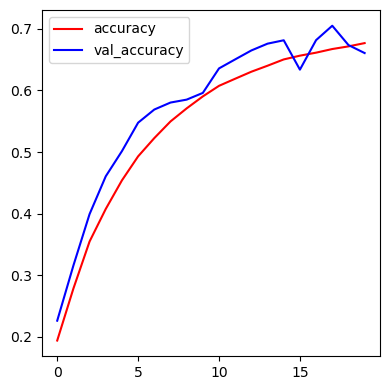

In [9]:
plt.figure(figsize = (4,4))
plt.plot(dense_history.history["accuracy"], color = "red", label = "accuracy")
plt.plot(dense_history.history["val_accuracy"], color = "blue", label = "val_accuracy")
plt.legend()
plt.tight_layout()

### Evaluate the performance of the model

#### Evaluate performance on the train set

In [16]:
labs_pred_proba = model1.predict(train_images_dnn)

print(classification_report(np.argmax(train_labels_dnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

1875/1875 [==============================] - 1s 495us/step
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      5923
           1       0.96      0.82      0.88      6742
           2       0.69      0.62      0.66      5958
           3       0.59      0.70      0.64      6131
           4       0.66      0.54      0.60      5842
           5       0.52      0.58      0.55      5421
           6       0.66      0.87      0.75      5918
           7       0.92      0.49      0.64      6265
           8       0.47      0.77      0.58      5851
           9       0.71      0.52      0.60      5949

    accuracy                           0.68     60000
   macro avg       0.70      0.67      0.67     60000
weighted avg       0.71      0.68      0.68     60000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

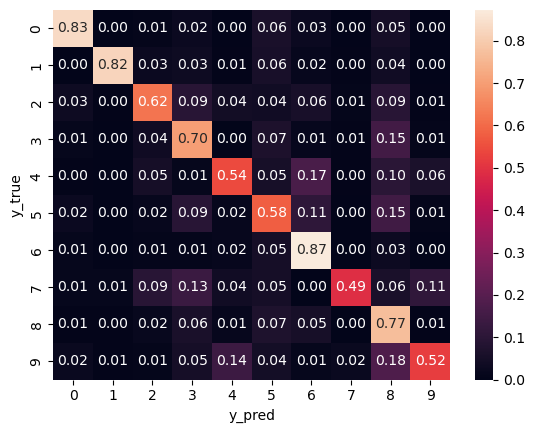

In [18]:
cm = sns.heatmap(confusion_matrix(np.argmax(train_labels_dnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")

In [19]:
# On the test set
labs_pred_proba = model1.predict(test_images_dnn)

print(classification_report(np.argmax(test_labels_dnn, axis = 1), np.argmax(labs_pred_proba, axis = 1)))

313/313 [==============================] - 0s 486us/step
              precision    recall  f1-score   support

           0       0.60      0.86      0.71       980
           1       0.96      0.35      0.51      1135
           2       0.24      0.91      0.38      1032
           3       0.65      0.49      0.55      1010
           4       0.59      0.32      0.42       982
           5       0.86      0.02      0.04       892
           6       0.65      0.73      0.69       958
           7       0.70      0.38      0.49      1028
           8       0.44      0.45      0.45       974
           9       0.75      0.27      0.40      1009

    accuracy                           0.48     10000
   macro avg       0.64      0.48      0.46     10000
weighted avg       0.64      0.48      0.47     10000



[Text(0.5, 23.52222222222222, 'y_pred'),
 Text(50.722222222222214, 0.5, 'y_true')]

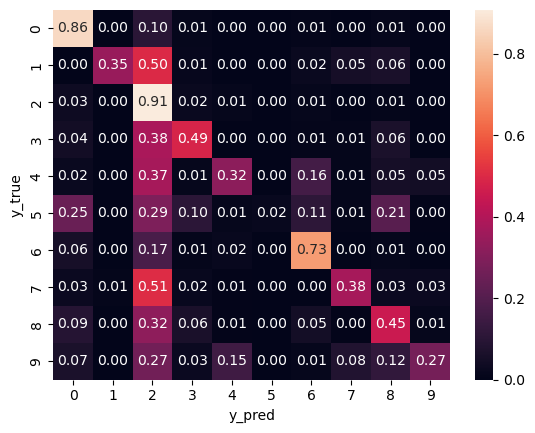

In [20]:
cm = sns.heatmap(confusion_matrix(np.argmax(test_labels_dnn, axis = 1),  np.argmax(labs_pred_proba, axis = 1), normalize = "true"),
                 annot = True, fmt='.2f')
cm.set(xlabel = "y_pred", ylabel = "y_true")